In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [4]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

train_data.shape, test_data.shape


((404, 13), (102, 13))

**Data Overview**

This data contains information on 506 areas in Boston. Each observation contains 13 numerical features that contain information about things like crime rate. The targets are median housing prices of owner-occupied homes (in thousands of USD) which exist on a continuous scale.

There are 506 samples, with 404 training and 102 test samples, and each contain 13 features.

The 13 features each have their own numerical scales. Some take values between 0 and 1, 1 and 12, 0 and 100, etc.


In [7]:
#Because all the features exist on their own scales, it is important to first normalize all the values for each feature 
#so they exists on a scale from 0 to 1. Recall we normalize via: norm_val = (val - feature_mean) / feature_std
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#we standardize test_data using the same parameters used for train_data so distributions are consistently transformed for comparison
test_data -= mean
test_data /=std

#NEVER USE QUANTITIES CPMPUTED FROM TEST DATA IN WORKFLOW, EVEN FOR THINGS LIKE NORMALIZATION. TEST DATA CANNOT TOUCH MODEL!!!!!!


**Model Architecture**

We don't have many samples (only 404) so overfitting is a big concern. We can reduce overfitting by using a small model, hence only a couple layers.

The final layer end with a single unit and no activation (linear layer), which is typical for scalar regression where you are trying to predict a single continuous value. Applying an activation function constrains the range of possible output values. For example, sigmoid activation constrains output values to be between 0 and 1. 

Note we use MAE (*mean absolute error*) as the metric, which gives the absolute value of the difference between predictions and targets in thousands of USD.


In [9]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model


**K-fold Validation**

Because we have so few data points, splitting the dataset into a training and validation set would create a very small validation set. As a consequence, the subset of data we use for our validation set could have large impacts on the validation scores. In other words, the small validation set creates high variation within validation scores. This makes it difficult to reliably evaluate our model. 

In these situations, best practice is to use *K-fold cross-validation*. K-fold vlidation triangulates error by taking the mean error of multiple runs of the model while ensuring each model run does not use the same validation data as the prior.

We split the data into K partitions (typicall K = 4 or 5), create K identical models, and then train each model using a different set of k-1 partitions. The validation score for the model is the average of the K validation scores obtained. 

Example where we split data into K = 3 partitions and use these partitions differently for each fold (run of identical model):

Fold 1: [Validation] [Training] [Training] => Validation score #1 (V1)

Fold 2: [Training] [Validation] [Training] => Validation score #2 (V2)

Fold 3: [Training] [Training] [Validation] => Validation score #3 (V3)

Final validation score for model = VF = mean(V1, V2, V3) = (V1 + V2 + V3) / 3


In [13]:
k = 4
num_val_samples = len(train_data) // k #determines number of indeces in one partition via floor division
num_epochs = 100
all_scores = []
for i in range(k):
    print('Processing fold ' + str(i))
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #extract validation data for Kth partition via slicing
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] #extracts validation data targets via slicing
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0) #concatenates rest of data (outside validation slice indeces) into training data
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0) #concatenates rest of targets (outside of valudation slice indeces) into training data
    
    model = build_model() #calls function from earlier that returns our model
    model.fit(partial_train_data, partial_train_targets,
        epochs=num_epochs, batch_size=16, verbose=0) #iterates over data for inputted number of epochs
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    


Processing fold 0


2022-08-21 19:51:42.052340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Processing fold 1
Processing fold 2
Processing fold 3


In [12]:
def k_fold_validation(k, num_epochs, num_batches, model, train_data, train_targets):
    all_scores = []
    num_val_samples = len(train_data) // k #determines number of indeces in one partition via floor division
    for i in range(k):
        print('Processing fold ' + str(i))
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #extract validation data for Kth partition via slicing
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] #extracts validation data targets via slicing

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]],
            axis=0) #concatenates rest of data (outside validation slice indeces) into training data
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]],
            axis=0) #concatenates rest of targets (outside of valudation slice indeces) into training data

        model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs, batch_size=num_batches, verbose=0) #iterates over data for inputted number of epochs
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)
        
    return all_scores
    

In [15]:
all_scores


[1.9763747453689575, 2.6056361198425293, 2.5282375812530518, 2.349081516265869]

In [22]:
print("Model's predictions vary by, on average, $" + str(np.round(np.mean(all_scores)*1000, 2)))


Model's predictions vary by, on average, $2364.83


In [54]:
#Now let's run the model with more epochs (500) and save the MAE history of every epoch. 
#Then we can calculate average per-epoch MAE core for all folds.

def k_fold_validation(k, num_epochs, num_batches, model, train_data, train_targets):
    all_mae_histories = []
    num_val_samples = len(train_data) // k #determines number of indeces in one partition via floor division
    for i in range(k):
        print('Processing fold #' + str(i + 1))
        val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] #extract validation data for Kth partition via slicing
        val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples] #extracts validation data targets via slicing

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
            train_data[(i + 1) * num_val_samples:]],
            axis=0) #concatenates rest of data (outside validation slice indeces) into training data
        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
            train_targets[(i + 1) * num_val_samples:]],
            axis=0) #concatenates rest of targets (outside of valudation slice indeces) into training data

        history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
            epochs=num_epochs, batch_size=num_batches, verbose=0) #iterates over data for inputted number of epochs
        mae_history = history.history["val_mae"]
        all_mae_histories.append(mae_history)
    #for each epoch calculate mean across every k-fold and store these in an array
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)] 
        
    return average_mae_history


In [55]:
average_mae_history = k_fold_validation(4, 500, 16, build_model(), train_data, train_targets)


Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


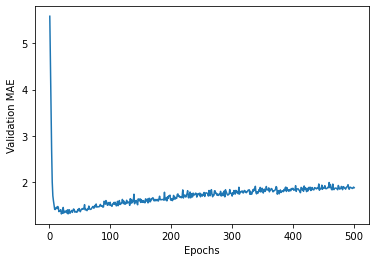

In [56]:
#Now we plot average MAE history to get a sense of how the model changed over epochs:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


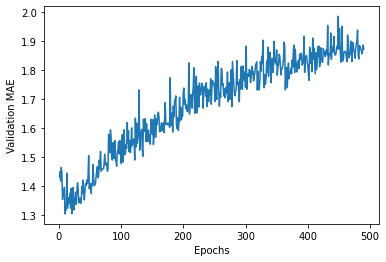

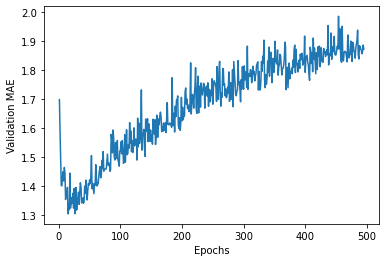

In [57]:
#Drop first 10 data points (epochs) to see what trend is closer up without large scale
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

truncated_mae_history = average_mae_history[5:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


In [65]:
#Looks like we hit our lowest MAE after around 30 epochs, so we are going to retrain out model for that target.
model = build_model()
model.fit(train_data, train_targets,
    epochs=150, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

#Oddly, our error is high around 30 epochs, and lowest around 150. The plot does not line up with our model outputs.


4/4 [==============================] - 0s 2ms/step - loss: 14.7819 - mae: 2.5466


2.546607732772827

In [66]:
#Can use predict to generate predictions for estimated median house price in thousands of dollars:
predictions = model.predict(test_data)
predictions[0]


4/4 [==============================] - 0s 1ms/step


array([9.281826], dtype=float32)